In [300]:
import numpy as np 
import pandas as pd 

import json
import time
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

#from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', 'input', 'Assignment-1.pdf', '.ipynb_checkpoints', 'electricity-demand-prediction.ipynb']


In [301]:
in_file_name = "Home1_yr1.csv"
out_file_name = "home1_out.csv"

In [302]:
column_names = ['load_demand']
house_data = pd.read_csv("./input/" + in_file_name, low_memory=False, nrows=None, names=column_names)
house_data.shape

(35040, 1)

In [303]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 1 columns):
load_demand    35040 non-null float64
dtypes: float64(1)
memory usage: 273.8 KB


In [304]:
house_data.describe()

,load_demand
count,35040.000000
mean,1.327208
std,1.399019
min,0.015124
25%,0.315678
50%,0.722875
75%,1.988425
max,15.500000


In [305]:

epochTime = 1417392000

def get_time_stamp(row):
    global epochTime
    epochTime+=900
    return pd.to_datetime(epochTime,unit='s')

house_data['time_stamp'] = house_data.apply (lambda row: get_time_stamp(row),axis=1)


In [306]:
house_data.head(10)

,load_demand,time_stamp
0,0.65018,2014-12-01 00:15:00
1,1.45400,2014-12-01 00:30:00
2,0.72971,2014-12-01 00:45:00
3,3.10750,2014-12-01 01:00:00
4,0.63572,2014-12-01 01:15:00
5,0.69720,2014-12-01 01:30:00
6,1.50610,2014-12-01 01:45:00
7,0.85858,2014-12-01 02:00:00
8,1.61320,2014-12-01 02:15:00
9,0.66075,2014-12-01 02:30:00


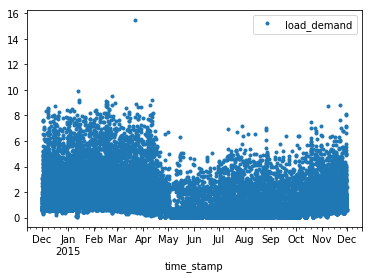

In [307]:
house_data.plot('time_stamp', 'load_demand', style=".")

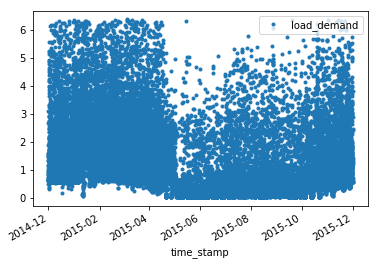

In [308]:
q = house_data["load_demand"].quantile(0.99)
house_data = house_data[house_data["load_demand"] < q]
house_data.plot('time_stamp', 'load_demand', style=".")

In [309]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-12-01', end='2015-11-30').to_pydatetime()

#get hour:minute format
def hour_minute(row_data):
    return (row_data.time_stamp.hour) #* 100 + (row_data.pickup_datetime.minute)

#get day_of_week format
def day_of_week(row_data):
    return (row_data.time_stamp.weekday())

def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.time_stamp)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0

#get month format
def get_month(row_data):
    return (row_data.time_stamp.month)

house_data['time_of_day'] = house_data.apply(lambda row: hour_minute(row), axis=1)
house_data['day_of_week'] = house_data.apply(lambda row: day_of_week(row), axis=1)
house_data['holiday'] = house_data.apply(lambda row: check_holiday(row), axis=1)
house_data['month_of_year'] = house_data.apply(lambda row: get_month(row), axis=1)
house_data['slot'] = np.array([i for i in range(1,len(house_data)+1)]).reshape(-1, 1)
house_data_copy = house_data.copy()
del house_data['time_stamp']

house_data.head(10)

,load_demand,time_of_day,day_of_week,holiday,month_of_year,slot
0,0.65018,0,0,0,12,1
1,1.45400,0,0,0,12,2
2,0.72971,0,0,0,12,3
3,3.10750,1,0,0,12,4
4,0.63572,1,0,0,12,5
5,0.69720,1,0,0,12,6
6,1.50610,1,0,0,12,7
7,0.85858,2,0,0,12,8
8,1.61320,2,0,0,12,9
9,0.66075,2,0,0,12,10


In [310]:
#get day_of_week format

#house_data.time_stamp[0].month

In [311]:
#Naive model

def Naive_Model(X):
    return X[-96:]

def Mean_Absolute_Error(x, y):
    return sum([abs(x[i] - y[i]) for i in range(len(y))])/(len(y) * 1.0)

day_value = 300
interval_count = day_value * 96
column = house_data.columns[0]
#print(house_data[column].values)
X_train = house_data[column].values[:interval_count]
X_test = house_data[column].values[interval_count:interval_count+96]
y = Naive_Model(X_train)
#print(X_test, y)
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, y))

Mean Absolute Error : 0.68495


In [312]:
#Linear Regression without additional features
linear_regression = LinearRegression()
final_columns = house_data.columns

linear_reg_train_X = np.array([i for i in range(1,len(X_train)+1)]).reshape(-1, 1)
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = np.array([len(X_train)+i for i in range(1,len(X_test)+1)]).reshape(-1, 1)
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))


Coefficients (a,b,c,..) :  [('load_demand', -8.0469161068079655e-05)]
Mean squared error: 0.98210
Variance : -0.24289
Mean Absolute Error : 0.45956


In [313]:
#Linear Regression with additional features
day_value = 300
interval_count = day_value * 96
column = house_data.columns[0]
linear_regression = LinearRegression()
final_columns = house_data.columns[1:]

linear_reg_train_X = house_data[final_columns][:interval_count]
linear_reg_train_Y = np.array(house_data[column].values[:interval_count])
linear_reg_test_X = house_data[final_columns][interval_count:interval_count+96]
linear_reg_test_Y = np.array((house_data[column].values[interval_count:interval_count+96]))

linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)
linear_reg_predicted_Y = linear_regression.predict(linear_reg_test_X)
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(final_columns,linear_regression.coef_)])
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(linear_reg_test_Y, linear_reg_predicted_Y))

Coefficients (a,b,c,..) :  [('time_of_day', 0.04065251512578584), ('day_of_week', -0.0033019520460361822), ('holiday', -0.011613273902253269), ('month_of_year', -0.065974132637976274), ('slot', -7.3003021310707883e-05)]
Mean squared error: 0.94811
Variance : -0.19988
Mean Absolute Error : 0.59693


In [314]:
from fbprophet import Prophet

df = pd.DataFrame({"ds":house_data_copy["time_stamp"].values})
df['y'] = house_data_copy['load_demand']
df.reset_index(drop=False,inplace=True)

fed_holiday = pd.DataFrame({"ds":house_data_copy["time_stamp"].values})
fed_holiday['holiday'] = house_data_copy['holiday']
fed_holiday = fed_holiday[fed_holiday['holiday'] == 1]

fed_holiday['holiday'] = fed_holiday.apply(lambda row: 'holiday', axis=1)

m = Prophet(yearly_seasonality=True, holidays=fed_holiday)
m.fit(df)

future = m.make_future_dataframe(periods=24 * 60, freq='min')
#print(future)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
36124,2015-12-01 23:56:00,1.862769,0.593510,3.131359
36125,2015-12-01 23:57:00,1.862676,0.618227,3.141033
36126,2015-12-01 23:58:00,1.862591,0.613639,3.143220
36127,2015-12-01 23:59:00,1.862513,0.581966,3.124204
36128,2015-12-02 00:00:00,1.862444,0.592993,3.146820


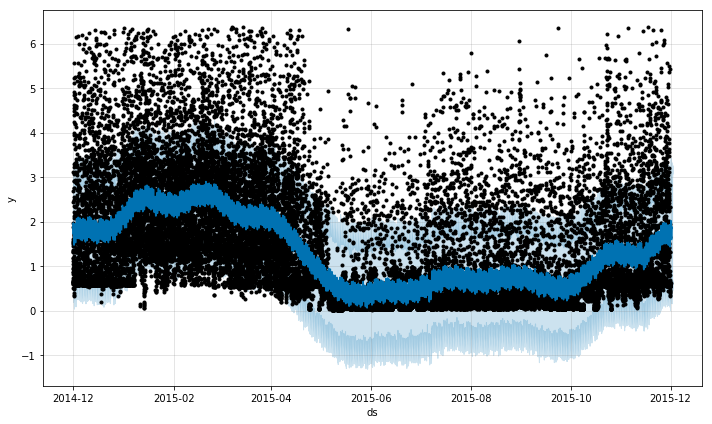

In [315]:
fig1 = m.plot(forecast)

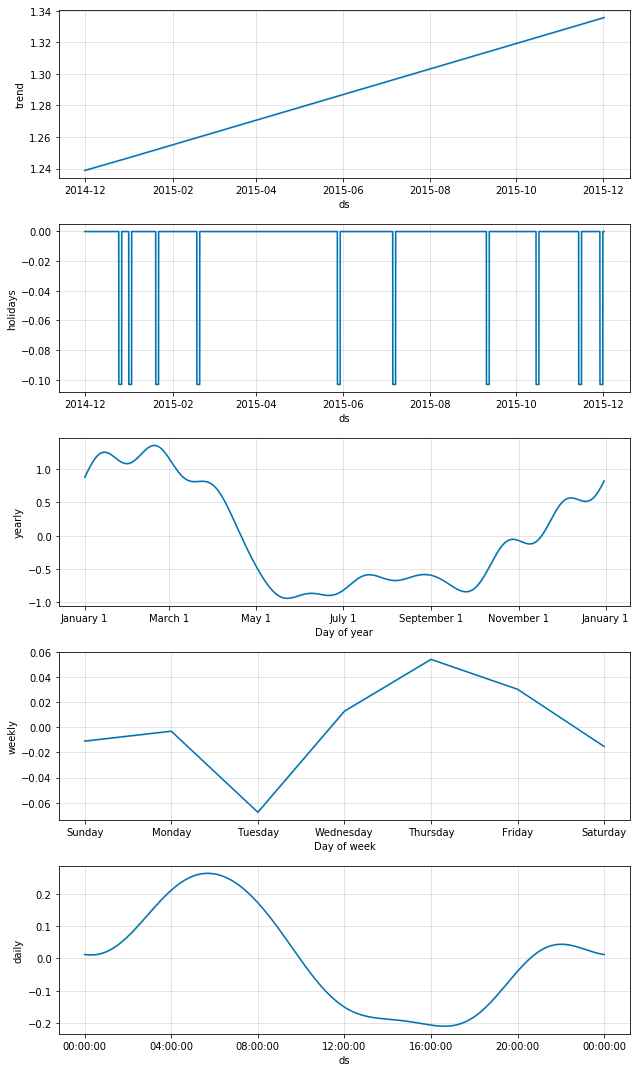

In [316]:
fig2 = m.plot_components(forecast)

In [317]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

model = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
linear_reg_predicted_Y = model_fit.predict(len(X_train), len(X_train)+95)
print(len(linear_reg_predicted_Y), len(X_test))
print("Mean Absolute Error : %.5f" % Mean_Absolute_Error(X_test, linear_reg_predicted_Y))


96 96
Mean Absolute Error : 0.45026
